In [1]:
import openmc
import numpy as np
from Meshing.Meshing import *
from Fields.Fields import *
from Kernels.Kernels import *
from Solvers.Solvers import *
from Subchannel.FluidRelation import FluidRelation
from Subchannel.Channel import Channel
from Subchannel.Channel import ChannelInterface
from Aux.CSVObjects import *
from Aux.ReactorPhysicsObjects import *

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.patches import Rectangle

import pandas as pd

In [2]:
# FLUID
fluid = FluidRelation(cp=1983, mu=0.00744, k=1.44, rho_0 = 2715.13, drho_dT=-0.513)

### BC DATA ###
# mdot_csv = load_csv('Data/msre_flow_coastdown.csv')
mdot_csv = load_csv('Data/mass_flow_startup.csv')
MDOT_MAX = 1.31293371E-01
START_TIME = -100
mdot_bc = MDOT_MAX / 100 * csv_interpolator(csv_df=mdot_csv, x_value=START_TIME, x_label='time', y_label='mdot')

T_bc = 900.0
pressure_bc = 101000.0

# INPUT DATA
gravity = 9.81
temp_tolerance = 1
max_temp_iterations = 1000
nZones = 50
L0 = 0
L1 = 67*2.54/100
heat_source = 0.0
fric = 'type1'

# comp. areas
up_area = 2.27228780E-04
lp_area = 2.21402401E-04
ex_area = 3.17945500E-04
dc_area = 7.57429265E-05
ch_area = 2.87587162E-04

# comp. hydraulic diameters
dc_dh = 1
ex_dh = 1
up_dh = 1
lp_dh = 1
lp_dh = 1
ch_dh = 0.0158276279311347000000

### TRACER DATA ###
tracer_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6']
initial_value_tracers = 0.0
scheme_tracers = 'upwind'
# dnp data from openmc
decay_consts = [0.01334, 0.03273, 0.1208, 0.3029, 0.8498, 2.854]
beta = [0.000228, 0.001177, 0.001124, 0.002522, 0.001036, 0.000434]
# singh et al nonlinear dynamic model of the msre
# decay_consts = [0.0124, 0.0305, 0.111, 0.301, 1.14, 3.01]
# beta = [2.23e-4, 14.57e-4, 13.07e-4, 26.28e-4, 7.66e-4, 2.80e-4]

# other tracer stuff
boundary = 'lower' # must be lower anyways
phi_tracer = 1.0
rho_tracer = 1.0


In [3]:
# SET CHANNELS UP FROM FULL CORE SOLUTION (NEED TO RUN COASTDOWN SIMULATION FIRST)
upper_plenum_channel = Channel.import_from_pkl(filename='Data/model_8_channels/upper_plenum.pkl')
lower_plenum_channel = Channel.import_from_pkl(filename='Data/model_8_channels/lower_plenum.pkl')
ex_channel = Channel.import_from_pkl(filename='Data/model_8_channels/external_loop.pkl')
downcomer_channel = Channel.import_from_pkl(filename='Data/model_8_channels/downcomer.pkl')


ch = Channel.import_from_pkl(filename='Data/model_8_channels/all_channels_homogenized.pkl')
# set bcs for the channel array.
ch.set_bcs(pressure_bc=pressure_bc,
           T_bc=T_bc,
           mdot_bc=mdot_bc,
           tracer_name_value_pairs={}, tracer_bool=False, th_bool=True)

# INTEGRATE AND WRITE OUT SOURCES
ch_FV = ch.integrate_tracer_source(tracer_name='c1')
up_FV = upper_plenum_channel.integrate_tracer_source(tracer_name='c1')
lp_FV = lower_plenum_channel.integrate_tracer_source(tracer_name='c1')
dc_FV = downcomer_channel.integrate_tracer_source(tracer_name='c1')
total_FV = ch_FV + up_FV + lp_FV + dc_FV
print('FV for each component')
print(ch_FV/total_FV)
print(up_FV/total_FV)
print(lp_FV/total_FV)
print(dc_FV/total_FV)
print('\nresident times for each component')

### PRINT CHANNEL RESIDENCE TIMES
print(ch.get_channel_residence_time())
print(upper_plenum_channel.get_channel_residence_time())
print(ex_channel.get_channel_residence_time())
print(downcomer_channel.get_channel_residence_time())
print(lower_plenum_channel.get_channel_residence_time())
print("total residence time =", ch.get_channel_residence_time()
      + upper_plenum_channel.get_channel_residence_time()
      + ex_channel.get_channel_residence_time()
      + downcomer_channel.get_channel_residence_time()
      + lower_plenum_channel.get_channel_residence_time())

### NOW GET / DO STUFF WITH SOURCES FOR FISSION SOURCES.
ch_F = ch.tracer_kernels['c1'][2].Q
up_F = upper_plenum_channel.tracer_kernels['c1'][2].Q
lp_F = lower_plenum_channel.tracer_kernels['c1'][2].Q
downcomer_F = downcomer_channel.tracer_kernels['c1'][2].Q
ex_F = ex_channel.tracer_kernels['c1'][2].Q

# delete all these now that we are done working with them so we dont make mistakes later on
del ch
del upper_plenum_channel
del lower_plenum_channel
del ex_channel
del downcomer_channel

FV for each component
0.871027881268014
0.0765366846730623
0.030684087327242884
0.021751346731680877

resident times for each component
8.818792965285484
3.900000005325571
5.457869158342907
1.3000000017751887
3.7999999986064488
total residence time = 23.2766621293356


In [4]:
# SET UP CHANNELS NOW #
upper_plenum_channel = Channel(gravity=gravity,
              Dh=1.0,
              area=up_area,
              temp_tolerance=temp_tolerance,
              max_temp_iterations=max_temp_iterations,
              nZones=nZones,
              L0=0.0,
              L1=1.0,
              fluid=fluid,
              pressure_bc=pressure_bc,
              T_bc=T_bc,
              mdot_bc=1.0,
              fric='none',
              heat_source=heat_source)

lower_plenum_channel = Channel(gravity=gravity,
              Dh=1.0,
              area=lp_area,
              temp_tolerance=temp_tolerance,
              max_temp_iterations=max_temp_iterations,
              nZones=nZones,
              L0=0.0,
              L1=1.0,
              fluid=fluid,
              pressure_bc=pressure_bc,
              T_bc=T_bc,
              mdot_bc=1.0,
              fric='none',
              heat_source=heat_source)

ex_channel = Channel(gravity=gravity,
              Dh=1.0,
              area=ex_area,
              temp_tolerance=temp_tolerance,
              max_temp_iterations=max_temp_iterations,
              nZones=nZones,
              L0=0.0,
              L1=1.0,
              fluid=fluid,
              pressure_bc=pressure_bc,
              T_bc=T_bc,
              mdot_bc=1.0,
              fric='none',
              heat_source=heat_source)

downcomer_channel = Channel(gravity=gravity,
              Dh=1.0,
              area=dc_area,
              temp_tolerance=temp_tolerance,
              max_temp_iterations=max_temp_iterations,
              nZones=nZones,
              L0=0.0,
              L1=1.0,
              fluid=fluid,
              pressure_bc=pressure_bc,
              T_bc=T_bc,
              mdot_bc=1.0,
              fric='none',
              heat_source=heat_source)

ch = Channel(gravity=gravity,
              Dh=ch_dh,
              area=ch_area,
              temp_tolerance=temp_tolerance,
              max_temp_iterations=max_temp_iterations,
              nZones=nZones,
              L0=L0,
              L1=L1,
              fluid=fluid,
              pressure_bc=pressure_bc,
              T_bc=T_bc,
              mdot_bc=1.0,
              fric='none',
              heat_source=heat_source)

# SET BCs for starting channel
ch.set_bcs(pressure_bc=pressure_bc, T_bc=T_bc, mdot_bc=mdot_bc, tracer_bool=False, th_bool=True, tracer_name_value_pairs={})

# SETUP INTERFACES BETWEEN CHANNELS
ch_to_up = ChannelInterface(ch1=ch, ch2=upper_plenum_channel)
up_to_ex = ChannelInterface(ch1=upper_plenum_channel, ch2=ex_channel)
ex_to_downcomer = ChannelInterface(ch1=ex_channel, ch2=downcomer_channel)
downcomer_to_lp = ChannelInterface(ch1=downcomer_channel, ch2=lower_plenum_channel)
lp_to_ch = ChannelInterface(ch1=lower_plenum_channel, ch2=ch)

# SETUP TRACERS
for tidx, name in enumerate(tracer_names):
  ch.add_tracer_to_channel(name=name,initial_value=initial_value_tracers,scheme=scheme_tracers,decay_const=decay_consts[tidx],
                           boundary=boundary,phi=phi_tracer,rho=rho_tracer,beta=beta[tidx],
                           source=ch_F)
  ex_channel.add_tracer_to_channel(name=name,initial_value=initial_value_tracers,scheme=scheme_tracers,decay_const=decay_consts[tidx],
                           boundary=boundary,phi=phi_tracer,rho=rho_tracer,beta=beta[tidx],
                           source=np.full(nZones, ex_F))
  downcomer_channel.add_tracer_to_channel(name=name,initial_value=initial_value_tracers,scheme=scheme_tracers,decay_const=decay_consts[tidx],
                           boundary=boundary,phi=phi_tracer,rho=rho_tracer,beta=beta[tidx],
                           source=np.full(nZones, downcomer_F))
  upper_plenum_channel.add_tracer_to_channel(name=name,initial_value=initial_value_tracers,scheme=scheme_tracers,decay_const=decay_consts[tidx],
                           boundary=boundary,phi=phi_tracer,rho=rho_tracer,beta=beta[tidx],
                           source=np.full(nZones, up_F))
  lower_plenum_channel.add_tracer_to_channel(name=name,initial_value=initial_value_tracers,scheme=scheme_tracers,decay_const=decay_consts[tidx],
                           boundary=boundary,phi=phi_tracer,rho=rho_tracer,beta=beta[tidx],
                           source=np.full(nZones, lp_F))

In [5]:
# st.st. solution for thermal hydraulics
ch.solve_channel_TH(_dt=1e321)
ch_to_up.update_interface_conditions(tracer_bool=False, th_bool=True)

upper_plenum_channel.solve_channel_TH(_dt=1e321)
up_to_ex.update_interface_conditions(tracer_bool=False, th_bool=True)

ex_channel.solve_channel_TH(_dt=1e321)
ex_to_downcomer.update_interface_conditions(tracer_bool=False, th_bool=True)

downcomer_channel.solve_channel_TH(_dt=1e321)
downcomer_to_lp.update_interface_conditions(tracer_bool=False, th_bool=True)

lower_plenum_channel.solve_channel_TH(_dt=1e321)
lp_to_ch.update_interface_conditions(tracer_bool=False, th_bool=True)

# St.St. Solution for tracers
ch_outlet_value = 1.0
iter_num = 0
tracer_to_converge_on = 'c1'
while True:
  iter_num += 1
  ch.solve_all_tracers(_dt=1e321)
  ch_to_up.update_interface_conditions(tracer_bool=True, th_bool=False)

  upper_plenum_channel.solve_all_tracers(_dt=1e321)
  up_to_ex.update_interface_conditions(tracer_bool=True, th_bool=False)

  ex_channel.solve_all_tracers(_dt=1e321)
  ex_to_downcomer.update_interface_conditions(tracer_bool=True, th_bool=False)

  downcomer_channel.solve_all_tracers(_dt=1e321)
  downcomer_to_lp.update_interface_conditions(tracer_bool=True, th_bool=False)

  lower_plenum_channel.solve_all_tracers(_dt=1e321)
  lp_to_ch.update_interface_conditions(tracer_bool=True, th_bool=False)

  tracer_outlet_weighted_value = ch.tracers[tracer_to_converge_on].T[-1]
  diff = np.abs(1 - tracer_outlet_weighted_value/ch_outlet_value)

  ch_outlet_value = tracer_outlet_weighted_value
  print("Iteration nuimber", iter_num, " and diff is", diff)
  if diff < 1e-12:
    break

Iteration nuimber 1  and diff is 0.9999999951811779
Iteration nuimber 2  and diff is 0.0


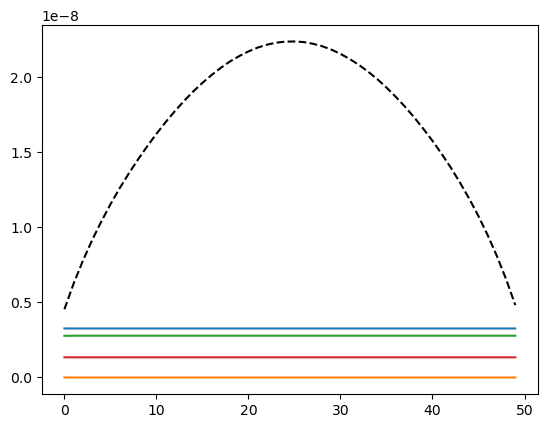

In [6]:
plt.plot(ch.tracers['c1'].T, 'k--')
plt.plot(upper_plenum_channel.tracers['c1'].T)
plt.plot(ex_channel.tracers['c1'].T)
plt.plot(downcomer_channel.tracers['c1'].T)
plt.plot(lower_plenum_channel.tracers['c1'].T)

In [7]:
total_source_times_V = ch.integrate_tracer_source(tracer_name='c1') + upper_plenum_channel.integrate_tracer_source(tracer_name='c1') + lower_plenum_channel.integrate_tracer_source(tracer_name='c1') + downcomer_channel.integrate_tracer_source(tracer_name='c1')

print(ch.integrate_tracer_source(tracer_name='c1')/total_source_times_V)
print(upper_plenum_channel.integrate_tracer_source(tracer_name='c1')/total_source_times_V)
print(lower_plenum_channel.integrate_tracer_source(tracer_name='c1')/total_source_times_V)
print(downcomer_channel.integrate_tracer_source(tracer_name='c1')/total_source_times_V)


0.8654628911921683
0.07983914953672927
0.03200806843074523
0.022689890840357396


In [8]:
# TIME SETTINGS
Tstart = -0.1
Tend = 50
nsteps = 2500

# TIMESTEPS
timesteps = np.linspace(Tstart, Tend, nsteps)

# Update old values in channel before starting simulation
ch.update_old_to_most_recent()
upper_plenum_channel.update_old_to_most_recent()
ex_channel.update_old_to_most_recent()
lower_plenum_channel.update_old_to_most_recent()
downcomer_channel.update_old_to_most_recent()

# Transient solver
t_prev = -1e321

# setup beff dict
beta_eff_dict_mc = {}

# Tracer names for stuff
tracer_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6']

for t_new in timesteps:
  # DT
  this_dt = t_new - t_prev
  # PRINT TIME INFORMATION
  print("NOW SOLVING AT TIME =", t_new, "| this_dt =", this_dt)
  # CHANGE MASS FLOW RATE AT CHANNEL INLET
  THIS_X_VALUE = t_new
  mdot_bc = MDOT_MAX / 100 * csv_interpolator(csv_df=mdot_csv, x_value=THIS_X_VALUE, x_label='time', y_label='mdot')
  ch.mdot_bc = mdot_bc
  print("\tmdot_bc =", mdot_bc)

  # THERMAL HYDRAULIC INFORMATION
  ch.solve_channel_TH(_dt=this_dt)
  ch_to_up.update_interface_conditions(tracer_bool=False, th_bool=True)

  upper_plenum_channel.solve_channel_TH(_dt=this_dt)
  up_to_ex.update_interface_conditions(tracer_bool=False, th_bool=True)

  ex_channel.solve_channel_TH(_dt=this_dt)
  ex_to_downcomer.update_interface_conditions(tracer_bool=False, th_bool=True)

  downcomer_channel.solve_channel_TH(_dt=this_dt)
  downcomer_to_lp.update_interface_conditions(tracer_bool=False, th_bool=True)

  lower_plenum_channel.solve_channel_TH(_dt=this_dt)
  lp_to_ch.update_interface_conditions(tracer_bool=False, th_bool=True)

  # TRACER TRANSIENT SOLUTION
  ch.solve_all_tracers(_dt=this_dt)
  ch_to_up.update_interface_conditions(tracer_bool=True, th_bool=False)

  upper_plenum_channel.solve_all_tracers(_dt=this_dt)
  up_to_ex.update_interface_conditions(tracer_bool=True, th_bool=False)

  ex_channel.solve_all_tracers(_dt=this_dt)
  ex_to_downcomer.update_interface_conditions(tracer_bool=True, th_bool=False)

  downcomer_channel.solve_all_tracers(_dt=this_dt)
  downcomer_to_lp.update_interface_conditions(tracer_bool=True, th_bool=False)

  lower_plenum_channel.solve_all_tracers(_dt=this_dt)
  lp_to_ch.update_interface_conditions(tracer_bool=True, th_bool=False)

  channel_array_weights = ch.get_channel_tracer_sources(tracer_name='c1')
  up_F = upper_plenum_channel.get_channel_tracer_sources(tracer_name='c1')
  lp_F = lower_plenum_channel.get_channel_tracer_sources(tracer_name='c1')
  downcomer_F = downcomer_channel.get_channel_tracer_sources(tracer_name='c1')

  this_beff_mc, _ = compute_beff_multichannel(channels=[ch, upper_plenum_channel, lower_plenum_channel, downcomer_channel],
                                              weights=[channel_array_weights, up_F, lp_F, downcomer_F],
                                              names=tracer_names)
  beta_eff_dict_mc[t_new] = this_beff_mc

  # Save channel data:
  ch.save_data(_t=t_new)
  upper_plenum_channel.save_data(_t=t_new)
  ex_channel.save_data(_t=t_new)
  lower_plenum_channel.save_data(_t=t_new)
  downcomer_channel.save_data(_t=t_new)

  ch.update_old_to_most_recent()
  upper_plenum_channel.update_old_to_most_recent()
  ex_channel.update_old_to_most_recent()
  lower_plenum_channel.update_old_to_most_recent()
  downcomer_channel.update_old_to_most_recent()

  t_prev = t_new


NOW SOLVING AT TIME = -0.1 | this_dt = inf
	mdot_bc = 1.3129337099999998e-07
NOW SOLVING AT TIME = -0.07995198079231694 | this_dt = 0.020048019207683065
	mdot_bc = 1.3129337099999998e-07
NOW SOLVING AT TIME = -0.05990396158463386 | this_dt = 0.02004801920768308
	mdot_bc = 1.3129337099999998e-07
NOW SOLVING AT TIME = -0.03985594237695079 | this_dt = 0.020048019207683072
	mdot_bc = 1.3129337099999998e-07
NOW SOLVING AT TIME = -0.019807923169267716 | this_dt = 0.020048019207683072
	mdot_bc = 1.3129337099999998e-07
NOW SOLVING AT TIME = 0.00024009603841534943 | this_dt = 0.020048019207683065
	mdot_bc = 1.3129337099999998e-07
NOW SOLVING AT TIME = 0.02028811524609843 | this_dt = 0.02004801920768308
	mdot_bc = 1.3129337099999998e-07
NOW SOLVING AT TIME = 0.04033613445378151 | this_dt = 0.02004801920768308
	mdot_bc = 1.3129337099999998e-07
NOW SOLVING AT TIME = 0.060384153661464574 | this_dt = 0.020048019207683065
	mdot_bc = 1.3129337099999998e-07
NOW SOLVING AT TIME = 0.08043217286914764 | t

In [9]:
msre_integral_worth = 'Data/msre_integral_rod_worth.csv'
msre_data = 'Data/msre_startup_datapoints.csv'

df = pd.read_csv(msre_integral_worth)
data = pd.read_csv(msre_data)

z = df['z'].values
rho = df[' rho'].values
pos = data['pos'].values
time_data = data['time'].values

startup_values = np.interp(pos, z, rho)

startup_base_insertion = startup_values[0]

(0.0, 300.0)

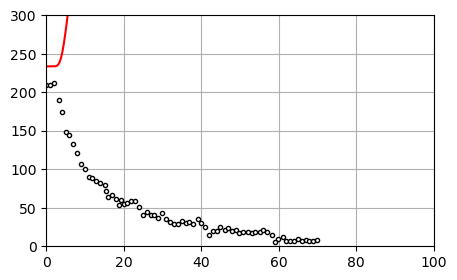

In [10]:
### EXP VALUES ###
msre_integral_worth = 'Data/msre_integral_rod_worth.csv'
msre_data = 'Data/msre_coastdown_datapoints.csv'

df = pd.read_csv(msre_integral_worth)
data = pd.read_csv(msre_data)

z = df['z'].values
rho = df[' rho'].values
pos = data['pos'].values
ornl_time_data = data['time'].values

values = np.interp(pos, z, rho)
base_insertion = values[0]

ornl_delta_rho_data = 1000*(values - startup_base_insertion) # this is the data we calculated based on experimental values

# MAKE PLOT
plt.figure(figsize=(5,3))
plt.plot(ornl_time_data, ornl_delta_rho_data, 'ko', markerfacecolor='w', markersize=3)

# COMPUTE STARTING VALUE
beff_no_flow = (0.006478751114635639 - 0.004142410989449852)*10**5

### MY VALUES ###
x = np.array(list(beta_eff_dict_mc.keys()))
y_MC = beta_eff_dict_mc[-0.1] - np.array(list(beta_eff_dict_mc.values()))
plt.plot(x, y_MC*10**5 + beff_no_flow, 'r-')
# plt.plot(x[0::50], y[0::50]*10**5, 'ks', markerfacecolor='w')
# plt.plot(x[0::50], y[0::50]*10**5, 'k+', markerfacecolor='w')

# OTHER PLOTTING STUFF
plt.grid()
plt.xlim([0,100])
plt.ylim([0,300])

0.006478751105941284


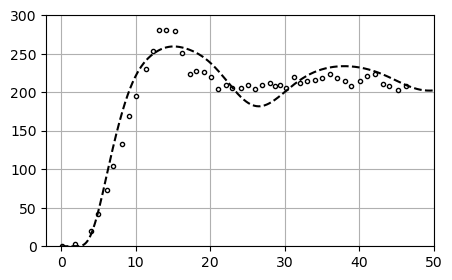

In [11]:
### EXP VALUES ###
msre_integral_worth = 'Data/msre_integral_rod_worth.csv'
msre_data = 'Data/msre_startup_datapoints.csv'

df = pd.read_csv(msre_integral_worth)
data = pd.read_csv(msre_data)

z = df['z'].values
rho = df[' rho'].values
pos = data['pos'].values
ornl_time_data = data['time'].values

values = np.interp(pos, z, rho)
base_insertion = values[0]
startup_base_insertion = values[0]

ornl_delta_rho_data = 1000*(values - base_insertion) # this is the data we calculated based on experimental values

# MAKE PLOT
plt.figure(figsize=(5,3))
plt.plot(ornl_time_data, ornl_delta_rho_data, 'ko', markerfacecolor='w', markersize=3)

### MY VALUES ###
x = np.array(list(beta_eff_dict_mc.keys()))
y_MC = beta_eff_dict_mc[-0.1] - np.array(list(beta_eff_dict_mc.values()))
plt.plot(x, y_MC*10**5, 'k--')
# plt.plot(x[0::50], y[0::50]*10**5, 'ks', markerfacecolor='w')
# plt.plot(x[0::50], y[0::50]*10**5, 'k+', markerfacecolor='w')

# OTHER PLOTTING STUFF
plt.grid()
plt.xlim([-2,50])
plt.ylim([0,300])
print(beta_eff_dict_mc[-0.1])

In [12]:
import pickle as pkl
with open("Results/ANS_2025/channel_1mod_startup_beta_eff_results.pkl", "wb") as file:
    pkl.dump(beta_eff_dict_mc, file)
